## Prediction of tropical storms intensity


TO DO:
        - column for month, year, hour
        - 
        


In [356]:
# Packages loading
import os
import pandas as pd
import numpy as np

# for ploting map
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs

import plotly.express as px

In [357]:
# Change current working directory
# current directory:
print(os.getcwd())
# set new directory
os.chdir('D:\_DSTI\A24_Python_Machine_learning\Project3_Tropical_storms')


D:\_DSTI\A24_Python_Machine_learning\Project3_Tropical_storms


## Dataset loading
IBTrACS dataset from NOAA.
International Best Track Archive for Climate Stewardship.
https://www.ncei.noaa.gov/products/international-best-track-archive

Objectif of the project :
Train a model to predict the severity of a tropical cyclone based on geographical input data.
Especially, we need to focus on predicting the value in the <b>TD9636_STAGE</b> column.




In [358]:
# Dataset loading
df = pd.read_csv('.\ibtracs.csv', header=0) 
df = df.iloc[1:] # remove 2nd line (with index 1).
df = df.reset_index() #reset indexes ;
# Add a column "Index" corresponding to the previous indexes. Can be removed.
#storms.head()
#print(storms)
# storms: dataframe 297098 lines, 175 columns (174 + 1 for old indexes)


C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\2115829982.py:2: DtypeWarning:

Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.



As we need to focus on the value in the <b>TD9636_STAGE</b> column, we can remove all lines where <b>TD9636_STAGE</b> is missing.
The TD9636 dataset was build in the 60-70s and is a collection of storms derived from multiple sources. It has not been updated since the 80s whereas the IBTrACS dataset is still updated. As a consequence it is not suprising that most of rows in TD9636_STAGE are empty.
TD9636 is a dataset for outside the Atlantic.

PROBLEM: 
Empty cells are in fact filled with a whitespace and thus NA are not properly detected

In [359]:
df.isna().sum()# it seems that there is no NA, which is false.

index                0
SID                  0
SEASON               0
NUMBER               0
BASIN            40518
                 ...  
USA_SEARAD_SE        0
USA_SEARAD_SW        0
USA_SEARAD_NW        0
STORM_SPEED          0
STORM_DIR            0
Length: 175, dtype: int64

In [360]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) # remove whitespace from every cells
df.replace('', np.nan, inplace=True) # replace empty cells with NA
df_NA = df.isna().sum() # it seems to work. 
# We can remove all columns filled only with NA

C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\1034959221.py:1: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\1034959221.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [361]:
# Now we can remove rows where there is NA in TD9636_STAGE
# TD9636_STAGE : 248755 missing data (84%)

df.dropna(subset = ['TD9636_STAGE'], inplace=True)

# Only 48343 rows left

# Data cleaning/feature engineering

First remove all rows filled only with NA :
- 75 columns

Columns to remove:

    - index: column added by Python when updating indexes after removing the 2nd line.
    - NAME: same as SID except that some storms don't have name. Redundant info
    - NUMBER: number of the storm for the year. Restart at 1 each year. Not useful.
    - BASIN 
    - SUBBASIN: Mostly missing. These two will probably be correlated to LAT and LON. Redundant info.
    - WMO_WIND: all data from agencies but differents units but no adjustement is made for differences in wind speed averaging. Data not comparable.
    - TD9636_WIND: in data description: "subjective, must be interpreted with caution". Not reliable.
    - WMO_AGENCY: info on agency from where WMO_ data come from.

    - IFLAG: info about data quality. Not necessary for model.
    - TRACK_TYPE: info about data quality. Not necessary for model.

    - BOM_PRES_METHOD: info on how BOM_PRES is measured

    - DS824_STAGE: lot of missing data but not surprising as it cover the period between 1877 and 1980. Our data are until 1989 thus we can remove this column.

    - NEUMANN_CLASS: lot of missing data. Not surprising as it cover only Southern Hemisphere and thus does not cover our entire study area.



Columns to keep: 

    - SID: unique ID for each storm
    - ISO_TIME: uniquely identify each record ? 
    - DIST2LAND
    - LANDFALL
    - LAT
    - LON

In [362]:
# Sum of NA per column:
df_NA = df.isna().sum() 
# Remove columns filled with NA
df = df.dropna(axis=1, how='all')
df_NA = df.isna().sum() 

In [363]:
# Columns that are not useful/full of NA/not reliable:
STORMS = df.drop(columns=['index', 'NAME', 'NUMBER',
                                    'BASIN', 'SUBBASIN',
                                    'WMO_WIND', 'TD9636_WIND', 
                                    'WMO_AGENCY',
                                    'IFLAG', 'TRACK_TYPE',
                                    'BOM_PRES_METHOD',
                                    'DS824_STAGE',
                                    'NEUMANN_CLASS'
                                    ])

In [364]:
# Remove duplicate LAT/LON data:
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_LAT', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_LON', case=True)]

In [365]:
STORMS.TD9636_STAGE.value_counts()

# stage are not equally represented, which is not suprising.
# but will be a problem for the model ?

TD9636_STAGE
2    17204
1    16028
4    10623
0     3156
3      742
5      331
6      259
Name: count, dtype: int64

In [366]:
df.BASIN.value_counts()


BASIN
WP    19796
SI    11008
EP     9831
SP     5752
NI     1956
Name: count, dtype: int64

Data available for
WP: Western North Pacific
SI: South Indian
EP: Eastern North Pacific
SP: South Pacific
NI: North Indian 

No data for North and South Atlantic (NA and SA) which is normal as TD9636 is a dataset for outside the Atlantic.

## WIND columns
_WIND columsn from the different agencies have different units, and thus can not be gather together easily :
     WMO_WIND: all data from agencies but differents units (no adjustement is made for differences in wind speed averaging)
     I suggest to remove it. No reliable.

     USA_WIND, DS824_WIND, NEUMANN_WIND, max speed 1-min averaged;
     CMA_WIND, max speed 2-min averaged;
     NEWDELHI_WIND, max speed 3-min averaged;
     TOKYO_WIND, HKO_WIND, KMA_WIND, REUNION_WIND, BOM_WIND, NADI_WIND, WELLINGTON_WIND max speed 10-min averaged;
     TD9636_WIND: in data description "estimates subjective, interpreted with caution". Remove it. 
     TD9635_WIND, MLC_WIND: only NA

We can take USA_WIND as a base because it is where there is the less NAN and complete the missing data with other columns, especially DS824_WIND and NEUMANN_WIND as it is supposed to be the same unit (max speed 1-min averaged).
Problem: data are not in the same unit 
To convert from max speed 10-min averaged to 1-min averaged : * 1.12
IBTrACS technical details p5: 
    "The U.S. agencies (NOAA and JTWC) report a 1 min averaging time for the sustained (i.e. relatively long-lasting) winds. In most of the rest of the world, a 10 min averaging time is used for "sustained wind". It is possible to convert from peak 10 min wind to peak 1 min wind (roughly 12% higher for the latter) as a general rule."
It is not a very accurate method so I suggest not to use it too much.
(See part 6.2 Wind speed reporting differences from Technical details doc)

We create one column WIND to gather all wind data and one column AGENCY to track the origin of the data.

In [367]:
# convert data types : 
cols = STORMS.filter(like="_WIND").columns
STORMS[cols] = STORMS[cols].apply(pd.to_numeric, errors="coerce")
STORMS.dtypes

# Create the two columns "WIND" and "AGENCY":
STORMS["WIND"] = np.nan
STORMS["WIND_AGENCY"] = np.nan

sources_adj = [
    ("USA_WIND", 1.0),  # No adjustment
    ("DS824_WIND", 1.0),  # No adjustment
    ("NEUMANN_WIND", 1.0),  # No adjustment
    ("TOKYO_WIND", 1.12),  # Adjustment factor
    ("HKO_WIND", 1.12),
 #   ("KMA_WIND", 1.12),
    ("REUNION_WIND", 1.12),
    ("BOM_WIND", 1.12),
 #   ("NADI_WIND", 1.12),
    ("WELLINGTON_WIND", 1.12)
]

# Iterate through the sources
for source, factor in sources_adj:
    mask = pd.isna(STORMS["WIND"]) & ~pd.isna(STORMS[source])  # Where WIND is NA but source is not NA
    STORMS.loc[mask, "WIND"] = STORMS.loc[mask, source] * factor
    STORMS.loc[mask, "WIND_AGENCY"] = source

C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\4145608872.py:27: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'USA_WIND' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [368]:
# Then we can remove other _WIND columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_WIND', case=True)]

# PRESS columns

= Lowest surface pressure in the tropical cyclone
Supposed to be easily comparable between agencies.

     WMO_PRES: Minimal central pressure assigned by the responsible WMO Agency
     USA_PRES: (mb) Minimum sea level pressure. Seems less precise ?
     TOKYO_PRES: central pressure
     CMA_PRES: (mb) Minimum sea level pressure
     HKO_PRES: (mb) Minimum sea level pressure
     KMA_PRES: (mb) Minimum sea level pressure
     NEWDELHI_PRES: 
     REUNION_PRES:
     BOM_PRES 
     BOM_PRES_METHOD: indicate the tool, not useful for us?
     NADI_PRES:
     WELLINGTON_PRES
     DS824_PRES
     NEUMANN_PRES

Except BOM_PRES_METHOD, they all have the same unit and should be comparable.


In [369]:
# Problem: not exactly the same value and the LAT and LON are not EXACTLY the same.
PRES = STORMS.filter(like="PRES", axis =1)
PRES.isna().sum()

# Maybe we can do the mean of each value. 
# It will modify the data but smooth the error ?

WMO_PRES           33584
USA_PRES           46775
TOKYO_PRES         32937
CMA_PRES           33176
HKO_PRES           35341
NEWDELHI_PRES      48118
REUNION_PRES       45186
BOM_PRES           42193
WELLINGTON_PRES    43960
DS824_PRES         47998
NEUMANN_PRES       45442
dtype: int64

In [370]:
# convert data types : 
cols = STORMS.filter(like="_PRES").columns
STORMS[cols] = STORMS[cols].apply(pd.to_numeric, errors="coerce")
STORMS.dtypes

# create a new column PRESS that is the mean of all _PRESS columns
STORMS["PRESS"] = STORMS.filter(like = "_PRES") . mean(axis = 1)


In [371]:
# Then we can remove other _PRES columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_PRES', case=True)]

In [372]:
# Remove data from agency columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('USA_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('TOKYO_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('CMA_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('HKO_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('NEWDELHI_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('REUNION_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('BOM_', case=True)]

### At last we have :
14 columns:

    - SID: storm IDs
    - SEASON: Risk to be correlated with ISO_TIME ?
    - ISO_TIME: time of the measurement 
    - NATURE: ?
    - LAT
    - LON
    - DIST2LAND 
    - LANDFALL
    - TD9636_STAGE: TARGET
    - STORM_SPEED: will be correlated to WIND ?
    - STORM_DIR
    - WIND
    - WIND_AGENCY: Not useful for the model
    - PRESS

### Problem:
Still a lot of missing data for PRESS

In [373]:
# Sum of NA/column
STORMS.isna().sum()

SID                 0
SEASON              0
ISO_TIME            0
NATURE              0
LAT                 0
LON                 0
DIST2LAND           0
LANDFALL          450
TD9636_STAGE        0
STORM_SPEED         1
STORM_DIR           1
WIND             4054
WIND_AGENCY      4054
PRESS           17595
dtype: int64

In [374]:
# Nb of values per TD9636_STAGE stage
STORMS.TD9636_STAGE.value_counts().sort_index()
# Nb of values per stage is not homogenous at all but this is not surprising as some type of storms are more frequent than other.

TD9636_STAGE
0     3156
1    16028
2    17204
3      742
4    10623
5      331
6      259
Name: count, dtype: int64

In [375]:
# Nb of NA WIND data per TD9636_STAGE 
STORMS_NA = STORMS[STORMS["WIND"].isna()]
STORMS_NA.TD9636_STAGE.value_counts().sort_index()

TD9636_STAGE
0    2442
1    1159
2     159
4      39
5     118
6     137
Name: count, dtype: int64

In [376]:
# Nb of NA PRESS data per TD9636_STAGE 
STORMS_NA = STORMS[STORMS["PRESS"].isna()]
STORMS_NA.TD9636_STAGE.value_counts().sort_index()

TD9636_STAGE
0    2291
1    7474
2    4900
3     254
4    2639
5      21
6      16
Name: count, dtype: int64

For first trials we decide to remove all the remaining missing data.

In [377]:
# remove all remaining missing data:
DATA = STORMS.dropna()
DATA.isna().sum()
DATA.TD9636_STAGE.value_counts().sort_index()

# df.dropna(subset = ['TD9636_STAGE'], inplace=True)

TD9636_STAGE
0      393
1     8064
2    12207
3      488
4     7978
5      203
6      117
Name: count, dtype: int64

In [378]:
# convert data types : 
cols = STORMS.filter(items = ['SEASON', 'LAT', 'LON', 'STORM_SPEED', 'DIST2LAND', 'LANDFALL', 'STORM_DIR', 'TD9636_STAGE']).columns
DATA[cols] = DATA[cols].apply(pd.to_numeric, errors="coerce")
DATA.dtypes

# convert SID into categorical number
DATA['SID'] = DATA['SID'].astype('category').cat.codes

# Encoding the NATURE column
DATA= pd.concat([DATA,
                 pd.get_dummies(DATA.NATURE)],axis=1).drop(columns="NATURE")
# we keep it for now and we remove TS column (following K-1 rules)

C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\4041058045.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claire\AppData\Local\Temp\ipykernel_21588\4041058045.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [379]:
DATA

,SID,SEASON,ISO_TIME,LAT,LON,DIST2LAND,LANDFALL,TD9636_STAGE,STORM_SPEED,STORM_DIR,WIND,WIND_AGENCY,PRESS,DS,ET,MX,NR,TS
8,0,1980,1980-01-02 00:00:00,-11.2,173.0,767,767,1,3,130,30.0,USA_WIND,997.000000,False,False,False,False,True
9,0,1980,1980-01-02 03:00:00,-11.3,173.1,770,762,1,4,150,30.0,USA_WIND,995.000000,False,False,False,False,True
10,0,1980,1980-01-02 06:00:00,-11.6,173.2,762,760,1,5,150,30.0,USA_WIND,994.000000,False,False,False,False,True
11,0,1980,1980-01-02 09:00:00,-11.8,173.3,760,751,1,5,145,33.0,USA_WIND,992.000000,False,False,False,False,True
12,0,1980,1980-01-02 12:00:00,-12.0,173.5,751,720,2,6,140,35.0,USA_WIND,990.000000,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67395,556,1989,1989-12-27 18:00:00,13.8,146.8,1781,1781,4,9,315,45.0,USA_WIND,992.666667,False,False,False,False,True
67396,556,1989,1989-12-27 21:00:00,14.2,146.4,1826,1826,4,12,310,38.0,USA_WIND,998.000000,False,False,False,False,True
67397,556,1989,1989-12-28 00:00:00,14.6,145.9,1872,1872,1,14,310,30.0,USA_WIND,1004.000000,False,False,False,False,True
67398,556,1989,1989-12-28 03:00:00,15.0,145.3,1921,1921,1,12,300,28.0,USA_WIND,1006.000000,False,False,False,False,True


In [380]:
# sort data and add a unique ID
DATA.sort_values(by = ['SID', 'ISO_TIME'], ascending = True)
DATA['INDEX'] = DATA.reset_index().index

# Separate ISO_TIME into year, month, day and time
DATA['ISO_TIME'] = pd.to_datetime(DATA['ISO_TIME'])
DATA['YEAR'] = DATA['ISO_TIME'].dt.year
DATA['MONTH'] = DATA['ISO_TIME'].dt.month
DATA['DAY'] = DATA['ISO_TIME'].dt.day
DATA['TIME'] = DATA['ISO_TIME'].dt.hour # we keep only hours as all records are taken at fixed round hours. 

DATA.dtypes

SID                      int16
SEASON                   int64
ISO_TIME        datetime64[ns]
LAT                    float64
LON                    float64
DIST2LAND                int64
LANDFALL                 int64
TD9636_STAGE             int64
STORM_SPEED              int64
STORM_DIR                int64
WIND                   float64
WIND_AGENCY             object
PRESS                  float64
DS                        bool
ET                        bool
MX                        bool
NR                        bool
TS                        bool
INDEX                    int64
YEAR                     int32
MONTH                    int32
DAY                      int32
TIME                     int32
dtype: object

## Clean database
For first trials we decide to remove all the remaining missing data.
We work with this data: 

    - SID: storm IDs
    - NATURE: ?
    - LAT
    - LON
    - DIST2LAND 
    - LANDFALL
    - STORM_SPEED: will be correlated to WIND ?
    - STORM_DIR
    - WIND
    - PRESS
    - INDEX
    - YEAR
    - MONTH
    - DAY
    - TIME
    - INDEX

   - TD9636_STAGE: TARGET

In [381]:
# Database:
DATA = DATA[['SID',
            'DS',
            'ET',
            'MX',
            'NR',
            'LAT',
            'LON',
            'DIST2LAND',
            'LANDFALL',
            'STORM_SPEED',
            'STORM_DIR',
            'WIND',
            'PRESS',
            'INDEX',
            'YEAR',
            'MONTH',
            'DAY',
            'TIME',
            'INDEX',
            'TD9636_STAGE']]

# Plots


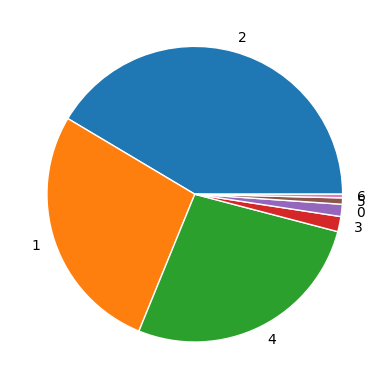

In [382]:
# Pie chart of 
plt.pie(DATA.TD9636_STAGE.value_counts(),
        labels=DATA.TD9636_STAGE.value_counts().index,
        labeldistance = 1.1,
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }
        )
plt.show()

In [383]:
# TD9636_STAGE distribution
tot_storms = px.scatter_geo(DATA, 
                     lat = "LAT",
                     lon = "LON",
                     color = "TD9636_STAGE",
                     projection="natural earth"
                    )
tot_storms
# The stage evolved along the storm trajectory.
# The stage starts at 1, increases, then decreases.




In [384]:
# storms that go until stage 6
sample_SID = DATA.loc[DATA['TD9636_STAGE'] == 6, 'SID']

sample = DATA.loc[DATA['SID'].isin(sample_SID)]

stage6 = px.scatter_geo(sample, 
                     lat = "LAT",
                     lon = "LON",
                     color = "TD9636_STAGE",
                     projection="natural earth"
                    )
stage6

## Correlation between variables


In [385]:
# data to check correlation:
corr = DATA.corr()

corr


,SID,DS,ET,MX,NR,LAT,LON,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,WIND,PRESS,INDEX,YEAR,MONTH,DAY,TIME,INDEX,TD9636_STAGE
SID,1.000000,-0.032743,-0.002861,-0.035185,-0.011078,0.102819,-0.238856,0.030366,0.030315,-0.017353,0.072934,0.018347,0.048266,0.999865,0.993763,0.088950,-0.004820,0.002551,0.999865,0.014786
DS,-0.032743,1.000000,-0.000583,-0.009597,-0.001871,0.011752,0.018618,0.027270,0.027049,0.011247,0.023266,-0.046884,0.038117,-0.033018,-0.032750,0.004019,-0.004621,0.006698,-0.033018,-0.070121
ET,-0.002861,-0.000583,1.000000,-0.003915,-0.000763,-0.000143,0.002068,-0.007798,-0.007783,0.055672,-0.004339,-0.005245,0.000497,-0.002779,-0.002384,-0.004546,0.012252,0.003534,-0.002779,0.001708
MX,-0.035185,-0.009597,-0.003915,1.000000,-0.012571,-0.046093,0.007693,0.009091,0.010098,0.097449,-0.064760,-0.183085,0.169534,-0.035246,-0.031219,-0.034324,0.017621,-0.009581,-0.035246,-0.100183
NR,-0.011078,-0.001871,-0.000763,-0.012571,1.000000,-0.079115,-0.010886,0.011850,0.011963,0.037205,-0.033064,-0.016603,0.019798,-0.010921,-0.007380,-0.033509,-0.014951,-0.005760,-0.010921,-0.036454
LAT,0.102819,0.011752,-0.000143,-0.046093,-0.079115,1.000000,0.118038,0.032751,0.027053,0.157009,0.143136,0.134520,-0.049528,0.103461,0.040053,0.618191,0.053392,-0.001324,0.103461,0.101574
LON,-0.238856,0.018618,0.002068,0.007693,-0.010886,0.118038,1.000000,-0.111094,-0.114856,0.067524,-0.064124,0.037102,-0.070675,-0.239335,-0.248365,0.082636,-0.011040,0.000391,-0.239335,0.009493
DIST2LAND,0.030366,0.027270,-0.007798,0.009091,0.011850,0.032751,-0.111094,1.000000,0.999500,0.052050,0.033381,0.061678,-0.035564,0.030484,0.023338,0.081012,-0.011431,-0.003219,0.030484,0.020476
LANDFALL,0.030315,0.027049,-0.007783,0.010098,0.011963,0.027053,-0.114856,0.999500,1.000000,0.041840,0.029889,0.057515,-0.032218,0.030418,0.023678,0.077126,-0.011903,-0.003413,0.030418,0.017580
STORM_SPEED,-0.017353,0.011247,0.055672,0.097449,0.037205,0.157009,0.067524,0.052050,0.041840,1.000000,-0.106000,0.023334,-0.010196,-0.016681,-0.025650,0.061282,-0.000143,-0.003930,-0.016681,0.068012


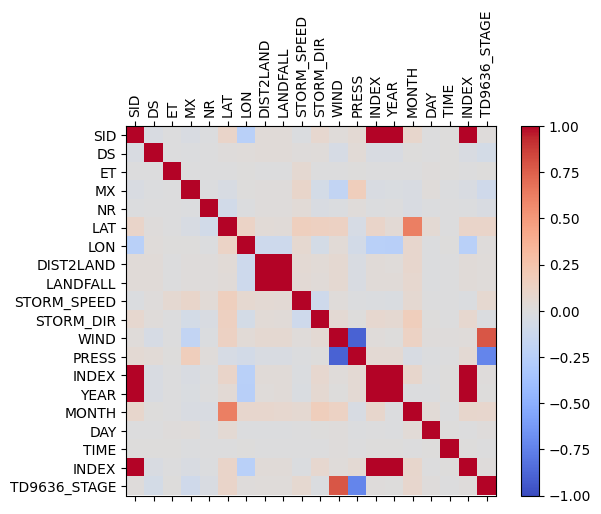

In [386]:

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(DATA.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(DATA.columns)
ax.set_yticklabels(DATA.columns)
plt.show()

DIST2LAND and LANDFALL are correlatd, we can keep just one
        --> we keep DIST2LAND (the description of the variable is clearer)

INDEX, SID, and YEAR are very are correlated
        --> we keep only INDEX 

WIND and PRESS are very correlated, which is not very surprising because in real life it should be correlated.

TD9636_STAGE correlated with WIND and PRESS, which is not supprising, it means that this variable are very informative to predict the STAGE. 



In [387]:
DATA = DATA.drop(columns=['LANDFALL', 'SID', 'YEAR'])

-----------------------
# Model part
-----------------------

In [408]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression


In [ ]:
# creation of the training and test datasets
DATA_train, DATA_test = train_test_split(DATA,test_size = 0.2)

DATA_train.TD9636_STAGE.value_counts().sort_index()
DATA_test.TD9636_STAGE.value_counts().sort_index()

TD9636_STAGE
0     319
1    6450
2    9765
3     392
4    6384
5     157
6      93
Name: count, dtype: int64

In [399]:
# get the values of the columns for the test data
x_train = DATA_train.loc[:,['DS',
                                'ET',
                                'MX',
                                'NR',
                                'LAT',
                                'LON',
                                'DIST2LAND',
                                'STORM_SPEED',
                                'STORM_DIR',
                                'WIND',
                                'PRESS',
                                'INDEX',
                                'MONTH',
                                'DAY',
                                'TIME',
                                'INDEX'
                                ]].values
    
y_train = DATA_train.TD9636_STAGE.values

We used the SMOTE procedure to rebalance the dataset.
We dcided to use it only for training dataset (DATA_train) as the test dataset is to verify our model and it is thus better to use empirical data rather than simulated data. 

In [407]:
# SMOTE procedure
sm = SMOTE(random_state=42)
x_SMOTE, y_SMOTE = sm.fit_resample(x_train, y_train)

x_SMOTE.value_counts()

#y_train.value_counts().sort_index()
# print('Resampled dataset shape %s' % Counter(y_SMOTE))

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

-----------------------
# Stop there
-----------------------
### Details on column choice

In [ ]:
# List of storms
IDS = df.loc[:, ["SID", "NAME", "NUMBER"]] 
# SID and Name are the same except that some storms don't have names so let's keep SID and remove Name
# NUMBER is the number of the storm for the year. Restart at 1 each year. Remove it. 
IDS.describe() # There are 4767 different storms
IDS.isna().sum() # No NA in SID. 

SID       0
NAME      0
NUMBER    0
dtype: int64

In [ ]:
# LAT columns
LAT = STORMS.filter(like="LAT", axis=1) # All columns containing "LAT" in their headers
LAT = STORMS[["SID"] + [col for col in STORMS.columns if "LAT" in col]]
# All latitudes are the same most of the time (+- 0.1, sometimes more but mostly the same).
# All these columns contains the same information. 
# LAT = LAT.loc[:, ['LAT']]
# LAT.isna().sum() # No na in column LAT

In [ ]:
# LONGITUDE
LON = STORMS.filter(like="LON", axis=1)
LON.isna().sum()
# same as with LAT, all longitudes are the same most of the time (+- 0.1, sometimes more but mostly the same).
# All these columns contains the same information. 
# LON = LON.loc[:, ['LON']]
# LON.isna().sum() # No na in column LAT

LON    0
dtype: int64

PROBLEM:
Sometime LAT/LON data are the same between agencies but sometimes we can see differences. 
Why ?
Is it because the measurements are not take exactly at the same point or is it because of measurement inaccuracies between instruments ?


Plot a few storms on a map:

In [ ]:
# Extract storms that have different LAT/LON within a same line:

sample_ID = ["1980069S12161",
             "1980092S15183", 
             "1980197N07154",
             "1981070N03173"]
sample = STORMS[STORMS["SID"].isin(sample_ID)] 

sample = sample[["SID"] 
                + ["ISO_TIME"] 
                + [col for col in sample.columns if "LAT" in col]
                + [col for col in sample.columns if "LON" in col]
                ]
sample_one = sample[["SID"] + ["LAT"] + ["LON"]]


In [ ]:
# Transpose the table

# Unpivot latitude and longitude columns
lat_melt = sample.melt(id_vars=['SID', 'ISO_TIME'], 
                   value_vars=[col for col in df.columns if col.endswith('_LAT')], 
                   var_name='agency_lat', 
                   value_name='latitude')

lon_melt = df.melt(id_vars=['SID', 'ISO_TIME'], 
                   value_vars=[col for col in df.columns if col.endswith('_LON')], 
                   var_name='agency_lon', 
                   value_name='longitude')

# Ensure the order matches between lat and lon
lat_melt['agency'] = lat_melt['agency_lat'].str.replace('_LAT', '', regex=False)
lon_melt['agency'] = lon_melt['agency_lon'].str.replace('_LON', '', regex=False)

# Merge latitude and longitude on ID, ISO_TIME, and agency
sample = pd.merge(lat_melt, lon_melt, on=['SID', 'ISO_TIME', 'agency'])

# Drop unnecessary columns
sample = sample.drop(columns=['agency_lat', 'agency_lon'])
sample = sample.dropna(subset = ["latitude"])


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['USA_LAT', 'TOKYO_LAT', 'CMA_LAT', 'HKO_LAT', 'NEWDELHI_LAT', 'REUNION_LAT', 'BOM_LAT', 'WELLINGTON_LAT', 'DS824_LAT', 'TD9636_LAT', 'NEUMANN_LAT']"

Plot the map storms with all the points

In [ ]:
fig = px.scatter_geo(sample, 
                     lat = "latitude",
                     lon = "longitude",
                     color = "SID",
                     projection="natural earth"
                    )
fig.show()

When zooming on the map, we can see that points sometimes there are points closed to the other one but the storm seems to have the same trajectory, just shifted. 
Therefore the difference between the differents LAT/LON pairs seem to be a matter of measurements inaccuracy.
We can keep just one.

In [ ]:
# Plot with only LAT LON

fig = px.scatter_geo(sample_one, 
                     lat = "LAT",
                     lon = "LON",
                     color = "SID",
                     projection="natural earth"
                    )
fig.show()


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['SID', 'LAT', 'LON'] but received: TD9636_STAGE

We don't loose a lot of information if we keep only LAT and LON.